In [1]:
import pandas as pd
house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')

### Define functions

In [2]:
def drop_anomolous_rows(df, colname, val):
    return df[df[colname] != val]

In [3]:
from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
# failed attempt to index     
# index = [colname +"_(1900-1909)", colname +"_(1910-1919)", colname +"_(1920-1929)", colname +"_(1930-1939)", colname +"_(1940-1949)", colname +"_(1950-1959)", colname +"_(1960-1969)", colname +"_(1970, 1979)", colname +"_(1980-1989)", colname +"_(1990-1999)", colname +"_(2000-2010)", colname +"_(2010-2020)"])
    series = pd.cut(df[colname], bins)
    cats = series.astype('category')
    
    return pd.get_dummies(cats)

In [4]:
def dummies_df(df, col_list):
    dummy_df = pd.DataFrame({})
    for column in col_list:
        d = pd.get_dummies(df[column], prefix=column + "_")
        dummy_df = pd.concat([dummy_df, d], axis=1)
    return dummy_df

# pd.get_dummies(df, columns=())

In [5]:
def clean():
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows

    clean_house = drop_anomolous_rows(house, 'bedrooms', 33)
    clean_house = drop_anomolous_rows(house, 'sqft_basement', "?")
    
# Build decade bins

    yr_built_df = bin_by_decade(house, 'yr_built')
    yr_renovated_df = bin_by_decade(house, 'yr_renovated')
    
# Get a df of dummies to append to clean_house

    clean_house_dummies = dummies_df(house, ['view', 'floors', 'bedrooms', 'condition', 'zipcode'])

# Append dummies to clean_house

    clean_house = pd.concat([clean_house, yr_built_df, yr_renovated_df, clean_house_dummies], axis=1)
    
# Drop columns that we created dummies for

    clean_house = clean_house.drop(['yr_built', 'yr_renovated', 'view', 'floors', 'bedrooms', 'condition', 'zipcode'], axis=1)

# Drop highly correlated features
    
    clean_house = clean_house.drop(['sqft_above', 'sqft_living', 'bathrooms', 'grade'], axis=1)
    
# Drop id, date, waterfront

    clean_house = clean_house.drop(['id', 'date', 'waterfront'], axis=1)
    
# Convert sqft_basement to from object to int

    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Get clean dataframe

In [6]:
clean_house = clean()


In [7]:
clean_house.isnull().sum()
clean_house2 =  clean_house.dropna()

In [8]:
clean_house2.isnull().sum()
len(clean_house2) - len(house)
len(house) - len(clean_house2)


454

### Checking for colinearity

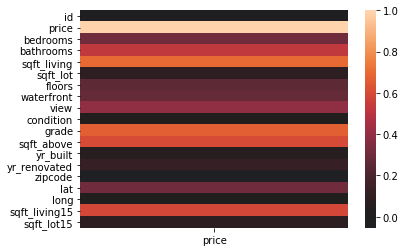

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(house.corr()[["price"]], center=0)
plt.show()


# sqft_above/sqft_living (87.7), bathrooms/sqft_living (75.5), grade/sqft_living(75.6)

### Investigating distributions

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


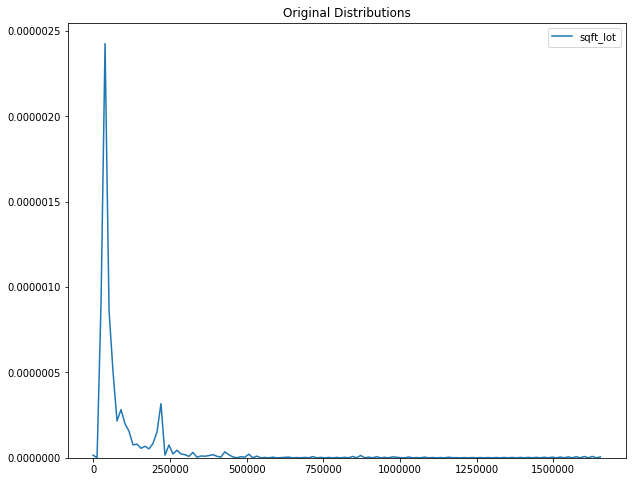

In [10]:
# plot original distribution plot
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

# sns.kdeplot(clean_house['price'], ax=ax1)
# sns.kdeplot(clean_house['lat'], ax=ax1)
sns.kdeplot(clean_house['sqft_lot'], ax=ax1)

### First pass at a shitty regression before scaling, standardizing

In [11]:
target = clean_house2["price"]
predictors = clean_house2.drop(["price"], axis=1)

import numpy as np
import statsmodels.api as sm
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target,predictors_int).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     408.7
Date:                Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                        17:02:43   Log-Likelihood:            -2.8818e+05
No. Observations:               21143   AIC:                         5.766e+05
Df Residuals:                   21021   BIC:                         5.776e+05
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.745e+07   5.35e+06     -3.260      0.001   -2.79e+07   -6.96e+06
sqft_lot           0.6063      0.049     12.372      0.000       0.510       0.702
sqft_basement     88.8331      3.981     22.312      0.000      81.029      96.637
lat             2.403e+05   8.05e+04      2.986      0.003    8.26e+04    3.98e+05
long           -1.179e+05   5.82e+04     -2.024      0.043   -2.32e+05   -3741.074
sqft_living15    185.8371      3.017     61.593      0.000     179.923     191.751
sqft_lot15         0.1179      0.078      1.520      0.128      -0.034       0.270
(1900, 1909]   -1.076e+04   1.04e+04     -1.032      0.302   -3.12e+04    9676.376
(1910, 1919]    3338.4744   9610.722      0.347      0.728   -1.55e+04    2.22e+04
(1920, 1929]    3894.4071   8254.438      0.472      0.637   -1.23e+04    2.01e+04
(1930, 1939]    2.718e+04   1.11e+04      2.458      0.014    5506.211    4.88e+04
(1940, 1949]   -1.186e+04   7222.721     -1.642      0.101    -2.6e+04    2300.557
(1950, 1959]   -3.359e+04   6653.011     -5.049      0.000   -4.66e+04   -2.05e+04
(1960, 1969]   -3.473e+04   6554.359     -5.299      0.000   -4.76e+04   -2.19e+04
(1970, 1979]   -4.496e+04   6669.438     -6.741      0.000    -5.8e+04   -3.19e+04
(1980, 1989]    -754.0758   6773.855     -0.111      0.911    -1.4e+04    1.25e+04
(1990, 1999]    2.516e+04   7133.853      3.527      0.000    1.12e+04    3.91e+04
(2000, 2010]     2.75e+04   6620.429      4.154      0.000    1.45e+04    4.05e+04
(2010, 2020]    6.444e+04   8406.722      7.666      0.000     4.8e+04    8.09e+04
(1900, 1909]   -6.455e-07   1.98e-07     -3.259      0.001   -1.03e-06   -2.57e-07
(1910, 1919]   -4.209e-07   1.29e-07     -3.256      0.001   -6.74e-07   -1.67e-07
(1920, 1929]    -1.18e-07   3.61e-08     -3.265      0.001   -1.89e-07   -4.72e-08
(1930, 1939]   -1.145e+05   2.02e+05     -0.566      0.572   -5.11e+05    2.82e+05
(1940, 1949]    5.082e+04   1.01e+05      0.501      0.616   -1.48e+05     2.5e+05
(1950, 1959]   -4.067e+04   5.23e+04     -0.777      0.437   -1.43e+05    6.19e+04
(1960, 1969]   -2.491e+04   3.98e+04     -0.626      0.532   -1.03e+05    5.31e+04
(1970, 1979]    -861.5123   3.54e+04     -0.024      0.981   -7.02e+04    6.84e+04
(1980, 1989]    3.279e+04   1.93e+04      1.702      0.089   -4978.369    7.06e+04
(1990, 1999]    7.526e+04   1.91e+04      3.948      0.000    3.79e+04    1.13e+05
(2000, 2010]    2.072e+05   1.43e+04     14.500      0.000    1.79e+05    2.35e+05
(2010, 2020]    7.971e+04   1.79e+04      4.452      0.000    4.46e+04    1.15e+05
view__0.0      -8.035e+04   2.59e+04     -3.100      0.002   -1.31e+05   -2.95e+04
view__1.0       6450.5986   2.82e+04      0.229      0.819   -4.89e+04    6.18e+04
view__2.0       2.291e+04   2.67e+04      0.857      0.391   -2.95e+04    7.53e+04
view__3.0   

### log transformation (didn't improve model)

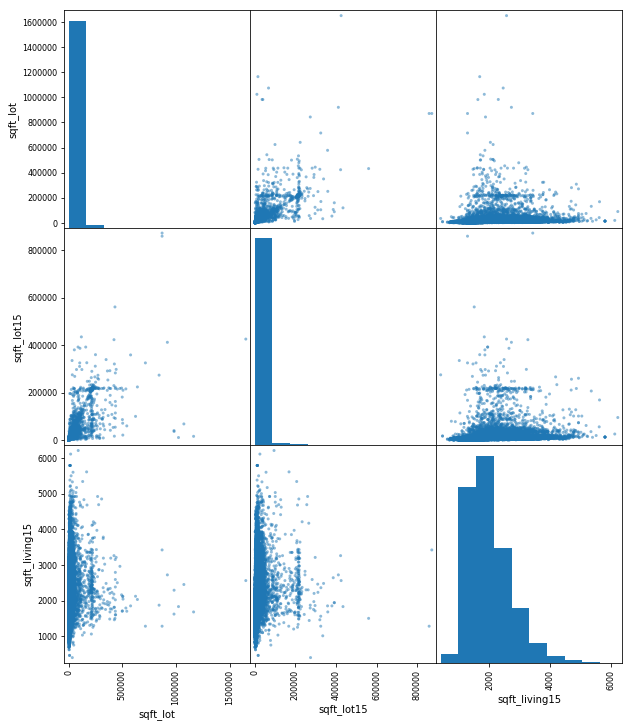

In [12]:
non_normal = ['sqft_lot', 'sqft_lot15', 'sqft_living15']

pd.plotting.scatter_matrix(clean_house2[non_normal], figsize=(10,12));

In [13]:
# for feat in non_normal:
#     clean_house2[feat] = clean_house2[feat].map(lambda x: np.log(x))

# pd.plotting.scatter_matrix(clean_house2[non_normal], figsize=(10,12));

In [14]:
# target = clean_house2["price"]
# predictors = clean_house2.drop(["price"], axis=1)

# import numpy as np
# import statsmodels.api as sm
# predictors_int = sm.add_constant(predictors)
# model = sm.OLS(target,predictors_int).fit()
# model.summary()

### Feature standardizing (neither min/max nor standard scalar applied to the whole df improved the model

In [15]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
clean_house2_mm = mm_scaler.fit_transform(clean_house2)

clean_house2_mm = pd.DataFrame(clean_house2_mm, columns=list(clean_house2.columns))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
target = clean_house2_mm["price"]
predictors = clean_house2_mm.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     408.7
Date:                Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                        17:02:47   Log-Likelihood:                 46863.
No. Observations:               21143   AIC:                        -9.348e+04
Df Residuals:                   21021   BIC:                        -9.251e+04
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0190      0.005      3.789      0.000       0.009       0.029
sqft_lot           0.1313      0.011     12.372      0.000       0.111       0.152
sqft_basement      0.0562      0.003     22.312      0.000       0.051       0.061
lat                0.0196      0.007      2.986      0.003       0.007       0.032
long              -0.0186      0.009     -2.024      0.043      -0.037      -0.001
sqft_living15      0.1417      0.002     61.593      0.000       0.137       0.146
sqft_lot15         0.0135      0.009      1.520      0.128      -0.004       0.031
(1900, 1909]      -0.0014      0.001     -1.032      0.302      -0.004       0.001
(1910, 1919]       0.0004      0.001      0.347      0.728      -0.002       0.003
(1920, 1929]       0.0005      0.001      0.472      0.637      -0.002       0.003
(1930, 1939]       0.0036      0.001      2.458      0.014       0.001       0.006
(1940, 1949]      -0.0016      0.001     -1.642      0.101      -0.003       0.000
(1950, 1959]      -0.0044      0.001     -5.049      0.000      -0.006      -0.003
(1960, 1969]      -0.0046      0.001     -5.299      0.000      -0.006      -0.003
(1970, 1979]      -0.0059      0.001     -6.741      0.000      -0.008      -0.004
(1980, 1989]   -9.893e-05      0.001     -0.111      0.911      -0.002       0.002
(1990, 1999]       0.0033      0.001      3.527      0.000       0.001       0.005
(2000, 2010]       0.0036      0.001      4.154      0.000       0.002       0.005
(2010, 2020]       0.0085      0.001      7.666      0.000       0.006       0.011
(1900, 1909]    2.696e-16   7.88e-17      3.423      0.001    1.15e-16    4.24e-16
(1910, 1919]   -5.581e-17   8.22e-17     -0.679      0.497   -2.17e-16    1.05e-16
(1920, 1929]    1.663e-16   5.52e-17      3.014      0.003    5.82e-17    2.74e-16
(1930, 1939]      -0.0150      0.027     -0.566      0.572      -0.067       0.037
(1940, 1949]       0.0067      0.013      0.501      0.616      -0.019       0.033
(1950, 1959]      -0.0053      0.007     -0.777      0.437      -0.019       0.008
(1960, 1969]      -0.0033      0.005     -0.626      0.532      -0.014       0.007
(1970, 1979]      -0.0001      0.005     -0.024      0.981      -0.009       0.009
(1980, 1989]       0.0043      0.003      1.702      0.089      -0.001       0.009
(1990, 1999]       0.0099      0.003      3.948      0.000       0.005       0.015
(2000, 2010]       0.0272      0.002     14.500      0.000       0.024       0.031
(2010, 2020]       0.0105      0.002      4.452      0.000       0.006       0.015
view__0.0         -0.0105      0.003     -3.100      0.002      -0.017      -0.004
view__1.0          0.0008      0.004      0.229      0.819      -0.006       0.008
view__2.0          0.0030      0.004      0.857      0.391      -0.004       0.010
view__3.0   

In [54]:
from sklearn import preprocessing
mm_scaler = preprocessing.StandardScaler()
clean_house2_ss = mm_scaler.fit_transform(clean_house2)

clean_house2_ss = pd.DataFrame(clean_house2_ss, columns=list(clean_house2.columns))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
target = clean_house2_ss["price"]
predictors = clean_house2_ss.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     408.7
Date:                Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                        17:45:25   Log-Likelihood:                -17211.
No. Observations:               21143   AIC:                         3.467e+04
Df Residuals:                   21021   BIC:                         3.564e+04
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.422e-15      0.004  -3.78e-13      1.000      -0.007       0.007
sqft_lot           0.0679      0.005     12.372      0.000       0.057       0.079
sqft_basement      0.1068      0.005     22.312      0.000       0.097       0.116
lat                0.0905      0.030      2.986      0.003       0.031       0.150
long              -0.0450      0.022     -2.024      0.043      -0.089      -0.001
sqft_living15      0.3462      0.006     61.593      0.000       0.335       0.357
sqft_lot15         0.0087      0.006      1.520      0.128      -0.003       0.020
(1900, 1909]      -0.0046      0.004     -1.032      0.302      -0.013       0.004
(1910, 1919]       0.0016      0.005      0.347      0.728      -0.007       0.010
(1920, 1929]       0.0023      0.005      0.472      0.637      -0.007       0.012
(1930, 1939]       0.0104      0.004      2.458      0.014       0.002       0.019
(1940, 1949]      -0.0084      0.005     -1.642      0.101      -0.019       0.002
(1950, 1959]      -0.0277      0.005     -5.049      0.000      -0.038      -0.017
(1960, 1969]      -0.0297      0.006     -5.299      0.000      -0.041      -0.019
(1970, 1979]      -0.0367      0.005     -6.741      0.000      -0.047      -0.026
(1980, 1989]      -0.0006      0.005     -0.111      0.911      -0.011       0.010
(1990, 1999]       0.0195      0.006      3.527      0.000       0.009       0.030
(2000, 2010]       0.0273      0.007      4.154      0.000       0.014       0.040
(2010, 2020]       0.0383      0.005      7.666      0.000       0.029       0.048
(1900, 1909]    1.167e-18   1.56e-17      0.075      0.940   -2.94e-17    3.17e-17
(1910, 1919]    3.194e-17   1.21e-17      2.650      0.008    8.32e-18    5.56e-17
(1920, 1929]   -1.526e-19   2.28e-17     -0.007      0.995   -4.49e-17    4.46e-17
(1930, 1939]      -0.0021      0.004     -0.566      0.572      -0.010       0.005
(1940, 1949]       0.0019      0.004      0.501      0.616      -0.006       0.009
(1950, 1959]      -0.0029      0.004     -0.777      0.437      -0.010       0.004
(1960, 1969]      -0.0024      0.004     -0.626      0.532      -0.010       0.005
(1970, 1979]    -9.24e-05      0.004     -0.024      0.981      -0.008       0.007
(1980, 1989]       0.0065      0.004      1.702      0.089      -0.001       0.014
(1990, 1999]       0.0151      0.004      3.948      0.000       0.008       0.023
(2000, 2010]       0.0558      0.004     14.500      0.000       0.048       0.063
(2010, 2020]       0.0170      0.004      4.452      0.000       0.010       0.024
view__0.0         -0.0656      0.021     -3.100      0.002      -0.107      -0.024
view__1.0          0.0022      0.009      0.229      0.819      -0.016       0.021
view__2.0          0.0128      0.015      0.857      0.391      -0.016       0.042
view__3.0   

### Feature selection

In [19]:
# copied function from Model Fit Linear Regression Lab

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [26]:
target = clean_house2_ss["price"]
predictors = clean_house2_ss(["price"], axis=1)

result = stepwise_selection(predictors, target, verbose = True)
print('resulting features:')
print(result)

TypeError: 'DataFrame' object is not callable

In [29]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 20)
selector = selector.fit(predictors, target)

In [48]:
selected_columns = clean_house2_ss.columns[selector.support_]
linreg.fit(clean_house2_ss[selected_columns], target)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 129 but corresponding boolean dimension is 128